# Predictive Modeling for Addressing Homelessness in California

## Project Overview
Homelessness is a critical and complex issue in the U.S., shaped by a variety of factors such as housing availability, economic conditions, and local policies. This project aims to develop predictive models to anticipate trends in homelessness, focusing on California counties, with the goal of optimizing resource allocation and supporting public services.

### Objectives
1. **Prediction Focus:** Develop a predictive model for homelessness rates by using socioeconomic and demographic data.
2. **Exploration and Insights:** Identify key contributing factors to homelessness through exploratory data analysis (EDA).
3. **Scalable Solution:** Validate the model's generalizability to states across the U.S.

In [1]:
# Loading dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

## **Data Sources**

The primary dataset is from the **U.S. Department of Housing and Urban Develeopment's Office of Policy Development**. This dataset was made to analyze market predictors of homeless, and how community factors shape homelessness rates within continuums of care.

The granularity of this dataset is CoC nnumber pear year. And each row has specific factors like:

- Climate
- Demographics
- Economic
- Geography
- Housing
- Local Policies
- Safety Nets
- Subgroups

In [2]:
data = pd.read_csv("data/05b_analysis_file_update.csv")
data.head()

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_rent75,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,3,1,1,1,1,0,0
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,0,3,1,1,1,1,0,0
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,3,1,1,1,1,0,0
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,0,3,1,1,1,1,0,0
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,3,1,1,1,1,0,0


**Features**
We organized and collected features in different categories in the `total_features.py` file. As you will see, each category has a lot of features.

In [3]:
from total_features import *

for category_name, features in feature_categories.items():
    print(f"{category_name}: {len(features)} features")
print("Total number of features:", sum(len(features) for features in feature_categories.values()))

climate_feats: 8 features
demographic_feats: 93 features
economic_feats: 34 features
housing_feats: 62 features
local_policies_feats: 5 features
safety_net_feats: 45 features
Total number of features: 247


This dateset is extremely large with lots of features. We think it would be easier if we can shorten the amount of variables use as a lot aren't very diffrent to each other.

## **Exploratory Data Analysis**

Let's select three features from each category (that we'll be predicting on) and compare to see how it relates toward **total homeless** from the `outcomes` array. There isn't much data that we need to create just because the dataset is super rich with data.

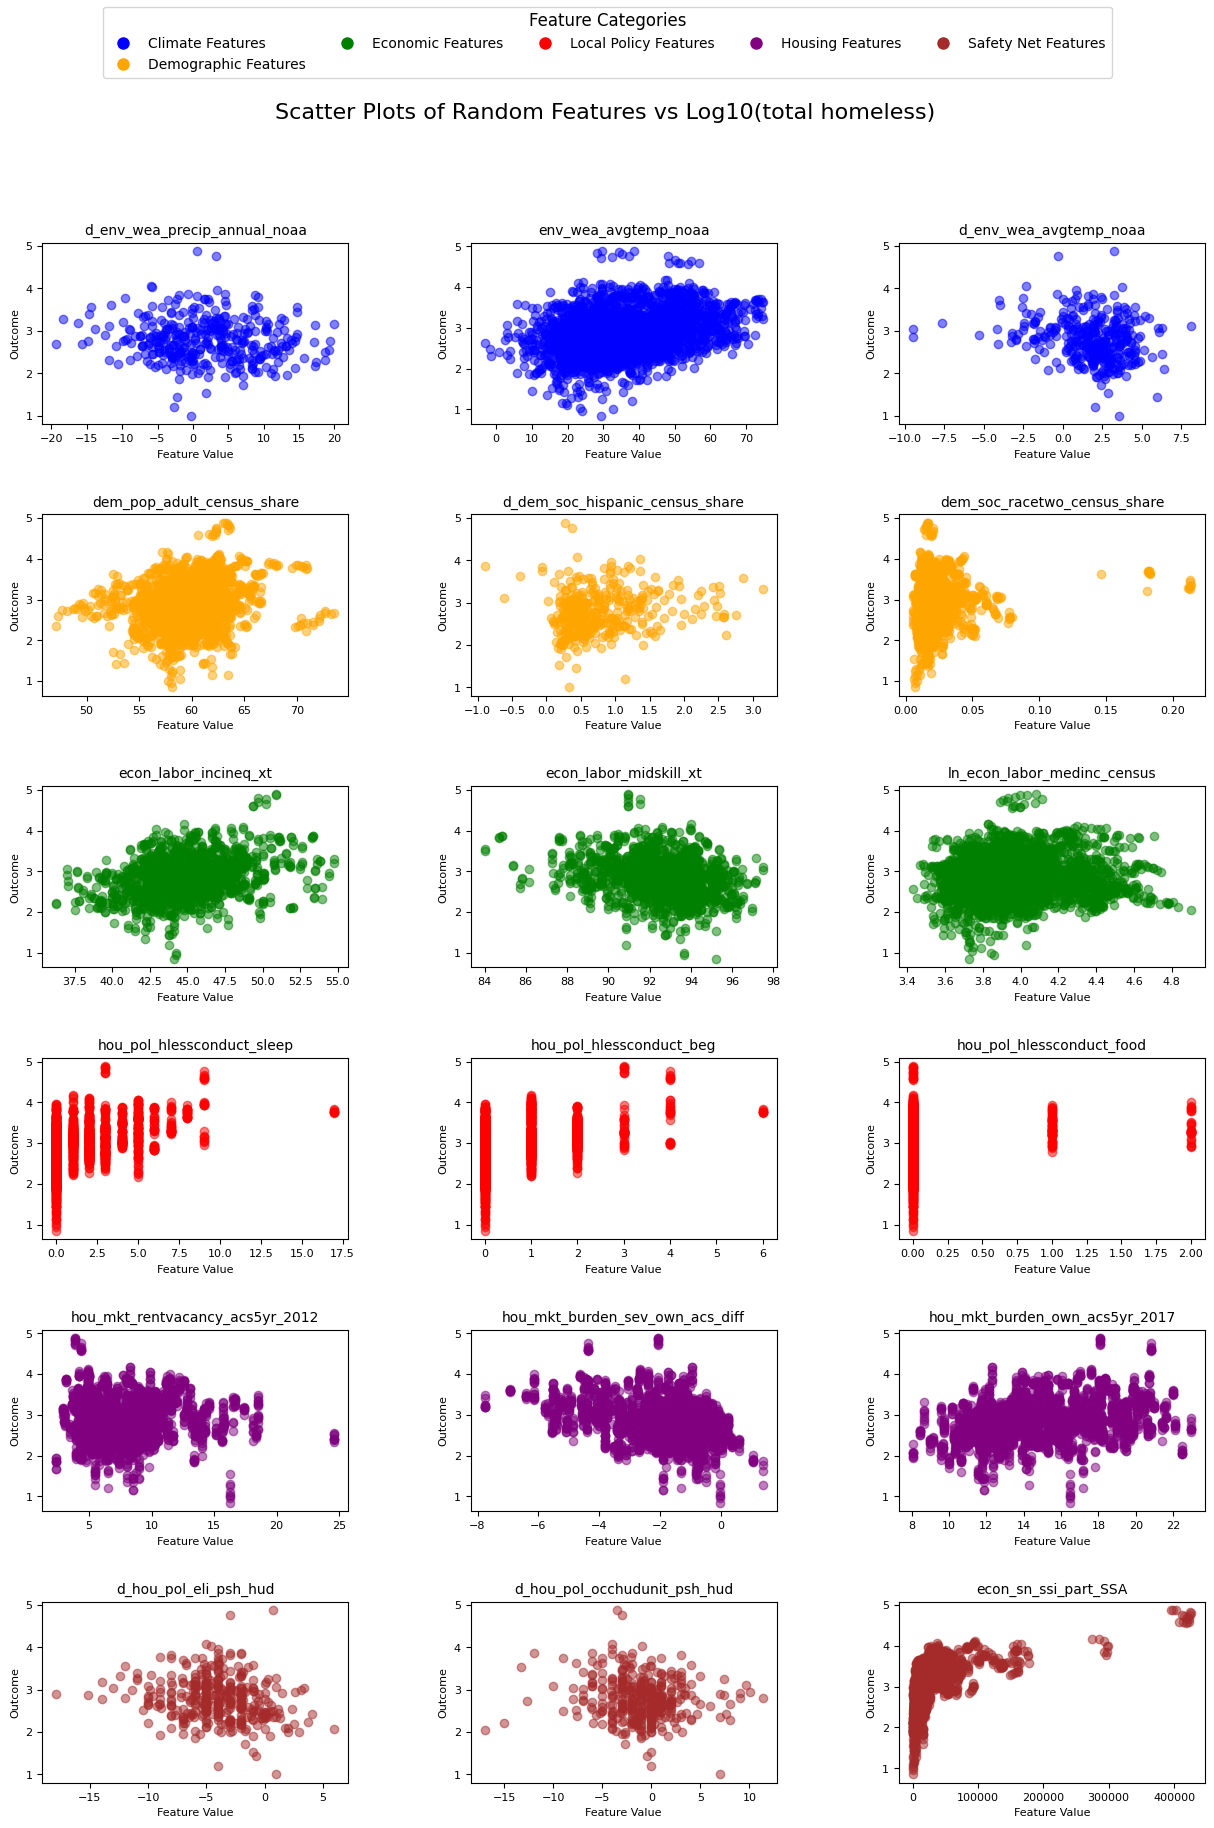

In [4]:
total_homeless = data['pit_tot_hless_pit_hud']
total_feats = [climate_feats, demographic_feats, economic_feats, local_policies_feats, housing_feats, safety_net_feats]
category_labels = [
    "Climate Features",
    "Demographic Features",
    "Economic Features",
    "Local Policy Features",
    "Housing Features",
    "Safety Net Features"
]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, feature_category in enumerate(total_feats):
    for j in range(3):  # Select 3 random features from each category
        feature_idx = np.random.choice(len(feature_category))
        category = feature_category[feature_idx]
        x = data[category]
        ax = axes[i, j]
        ax.scatter(x, np.log10(total_homeless), alpha=0.5, color=colors[i], label=category_labels[i] if j == 0 else "")
        ax.set_title(f"{category}", fontsize=10)
        ax.set_xlabel("Feature Value", fontsize=8)
        ax.set_ylabel("Outcome", fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)

fig.suptitle("Scatter Plots of Random Features vs Log10(total homeless)", fontsize=16, y=0.95)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=label) 
           for i, label in enumerate(category_labels)]
fig.legend(handles=handles, loc='upper center', ncol=5, fontsize=10, title="Feature Categories", title_fontsize=12)
plt.show()

Looking at distribution of number of total number of homeless people.

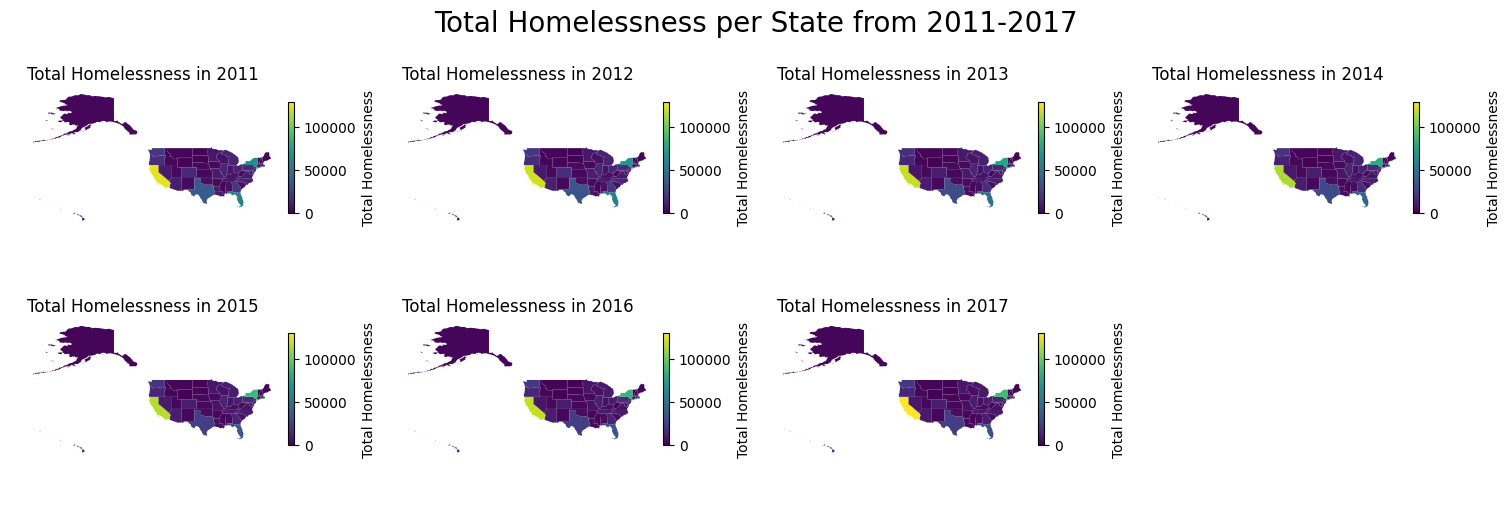

In [5]:
total_homeless_by_year_area = data.pivot_table(
    index='state_abr',
    columns='year',
    values='pit_tot_hless_pit_hud',
    aggfunc='sum')

total_homeless_by_year_area = total_homeless_by_year_area.sort_index()
states_map = gpd.read_file('data/tl_2024_us_state.shp')

total_homeless_by_year_area_df = total_homeless_by_year_area.reset_index()
merged = states_map.merge(total_homeless_by_year_area_df, left_on="STUSPS", right_on="state_abr", how="left")

years_to_plot = list(range(2011, 2018))  # Years 2011 to 2017
fig, axes = plt.subplots(2, 4, figsize=(15, 5), constrained_layout=True)
axes = axes.flatten()

for i, year in enumerate(years_to_plot):
    ax = axes[i]
    merged.plot(
        column=year, 
        ax=ax, 
        cmap="viridis", 
        legend=True, 
        legend_kwds={
            'shrink': 0.5,  # Smaller colorbar
            'label': 'Total Homelessness',  # Optional label
            'orientation': 'vertical'  # Ensure vertical orientation
        },
        vmin=0,
        vmax=130000
    )
    ax.set_xlim(-190, -65)
    ax.axis("off")
    ax.set_title(f"Total Homelessness in {year}", fontsize=12)

for j in range(len(years_to_plot), len(axes)):
    axes[j].axis("off")

plt.suptitle("Total Homelessness per State from 2011-2017", fontsize=20)
plt.show()

Here are some features that we think are important to predict on. We chose them based on absolute linear correlation, this should be useful for 

In [6]:
absolute_correlations = pd.Series(
    data[sum(feature_categories.values(), [])].corrwith(total_homeless).abs())

# Calculate correlations only for features in the current category
selected_features = {
    category: (
        absolute_correlations[feature_categories[category]]
        .nlargest(top_n)
        .index.tolist()
    )
    for category, top_n in [
        ('climate_feats', 5),
        ('demographic_feats', 20),
        ('economic_feats', 20),
        ('housing_feats', 20),
        ('local_policies_feats', 5),
        ('safety_net_feats', 20)
    ]
}

# Check for duplicates across categories
selected_features_unique = {}
seen_features = set()

for category, features in selected_features.items():
    unique_features = [f for f in features if f not in seen_features]
    selected_features_unique[category] = unique_features
    seen_features.update(unique_features)

# Include state and year for forecasting
selected_features = sum(selected_features_unique.values(), []) + ['state_abr', 'year']

# Print the final selected features by category
for category, features in selected_features_unique.items():
    print(f"\nCategory: {category}")
    print(f"Selected Features ({len(features)}):")
    for feature in features:
        print(f"  - {feature}")


Category: climate_feats
Selected Features (5):
  - env_wea_avgtemp_noaa
  - env_wea_precip_annual_noaa
  - d_env_wea_precip_noaa
  - d_env_wea_avgtemp_summer_noaa
  - d_env_wea_avgtemp_noaa

Category: demographic_feats
Selected Features (20):
  - dem_soc_asian_census
  - dem_pop_adult_census
  - dem_soc_hispanic_census
  - dem_pop_female_census
  - dem_pop_pop_census
  - dem_pop_male_census
  - dem_soc_racetwo_census
  - dem_pop_child_census
  - dem_pop_senior_census
  - dem_soc_black_census
  - dem_pop_density_census
  - dem_soc_white_census
  - dem_soc_white_census_share
  - dem_health_cost_dart
  - dem_soc_asian_census_share
  - dem_soc_pacific_census
  - dem_soc_vet_acs5yr_2012
  - dem_soc_hispanic_census_share
  - dem_soc_vet_acs5yr_2017
  - dem_soc_vet_xt

Category: economic_feats
Selected Features (20):
  - econ_labor_pov_pop_census
  - econ_labor_unemp_pop_BLS
  - econ_labor_force_pop_BLS
  - econ_labor_emp_pop_BLS
  - econ_labor_incineq_acs5yr_2017
  - econ_labor_incineq_acs5

## **Predicting Homelessness**

The first model we'll try is the one used by **HUD** to predict homelessness rates. This can be our baseline It considers six main categories of factors:

1. **Housing market variables** ($M_i$): such as rent costs and vacancy rates.
2. **Economic variables** ($E_i$): like unemployment rates and income levels.
3. **Safety net variables** ($S_i$): such as available support programs for the homeless.
4. **Demographic variables** ($D_i$): like population characteristics (age, race, etc.).
5. **Climate variables** ($W_i$): including weather and environmental factors.
6. **Local policy variables** ($L_i$): such as the number of food sharing or loitering laws.

To identify the most important features from each category, we compute the absolute correlations between each feature and the target variable (total homelessness). We then select the top features for each category:

- Climate: Top 5 features
- Demographics: Top 20 features
- Economic: Top 20 features
- Housing: Top 20 features
- Local Policies: Top 5 features
- Safety Net: Top 20 features

Duplicate features across categories are resolved, and we also include **state** ($A_i$) and **year** ($Y_i$) variables to account for differences between states and changes over time. These additions aim to improve the model’s performance by capturing temporal and geographical variations. The final feature set is standardized for better interpretability and faster processing.

The formula for the HUD model with selected features and additional variables is:

$$
\log_{10}(\hat{H_i}) = \hat{\alpha} +  \hat{\beta}_j M_{ij} +  \hat{\gamma}_k E_{ik} +  \hat{\delta}_l S_{il} +  \hat{\lambda}_m D_{im} +  \hat{\rho}_n W_{in} +  \hat{\sigma}_o L_{io} + \hat{\eta} Y_i + \hat{\kappa} A_i
$$

Where:
- $M_{ij}$, $E_{ik}$, $S_{il}$, $D_{im}$, $W_{in}$, and $L_{io}$ are the selected features for housing, economic, safety net, demographic, climate, and local policy variables, respectively.
- $\hat{\alpha}$, $\hat{\beta}_j$, $\hat{\gamma}_k$, $\hat{\delta}_l$, $\hat{\lambda}_m$, $\hat{\rho}_n$, $\hat{\sigma}_o$, $\hat{\eta}$, and $\hat{\kappa}$ are the corresponding coefficients.

The **target variable** ($H_i$) is log-transformed using $\log_{10}$ to normalize the large range of values and stabilize variance. The selected features are prepared as follows:
- **Feature Selection:** Features are chosen based on their absolute correlation with the target variable.
- **Standardization:** Features are standardized using `StandardScaler` to improve processing time and model performance.
- **Dummy Variables:** The `state_abr` variable is converted to dummy variables to represent categorical data numerically.

Finally, the dataset is split into training and testing sets for validation. This ensures the model is evaluated for its accuracy and generalization capability.

### **Data Preprocessing**

In [7]:
X = data.copy()[selected_features].fillna(0)
X = pd.get_dummies(X, columns = ['state_abr'], drop_first=True,dtype = float)

# Prepare target variable `y`
y = np.log10(data['pit_tot_hless_pit_hud']).fillna(0)  # Ensure no missing values in target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (for faster processing time)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier interpretability
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

### **Model 1: Linear Regerssion**

In [8]:
# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_train_lr = linear_model.predict(X_train)
y_pred_test_lr = linear_model.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train_lr)
mse_test = mean_squared_error(y_test, y_pred_test_lr)
r2_train = r2_score(y_train, y_pred_train_lr)
r2_test = r2_score(y_test, y_pred_test_lr)

# Print evaluation metrics
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MSE: 0.06475641177175238
Test MSE: 0.09008437095829022
Train R^2: 0.7786192000328273
Test R^2: 0.6990546544592308


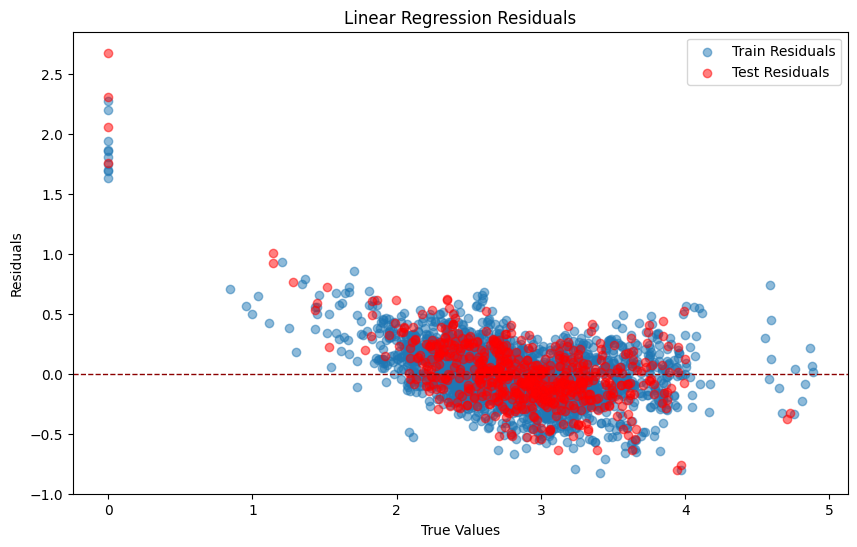

In [9]:
# Residuals plot
LR_train_residuals = y_pred_train_lr - y_train
LR_test_residuals = y_pred_test_lr - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, LR_train_residuals, alpha=0.5, label="Train Residuals")
ax.scatter(y_test, LR_test_residuals, alpha=0.5, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Linear Regression Residuals")
ax.legend()
plt.show()

LR_residuals_plot = fig

### **Model 2: Simple Regression Tree**

In [10]:
regr_tree = DecisionTreeRegressor()
regr_tree.fit(X_train, y_train)

# Make predictions
y_pred_train_rt = regr_tree.predict(X_train)
y_pred_test_rt = regr_tree.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_pred_train_rt)
mse_test = mean_squared_error(y_test, y_pred_test_rt)
r2_train = r2_score(y_train, y_pred_train_rt)
r2_test = r2_score(y_test, y_pred_test_rt)

# Print evaluation metrics
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MSE: 0.0
Test MSE: 0.06154426624384516
Train R^2: 1.0
Test R^2: 0.794398736720017


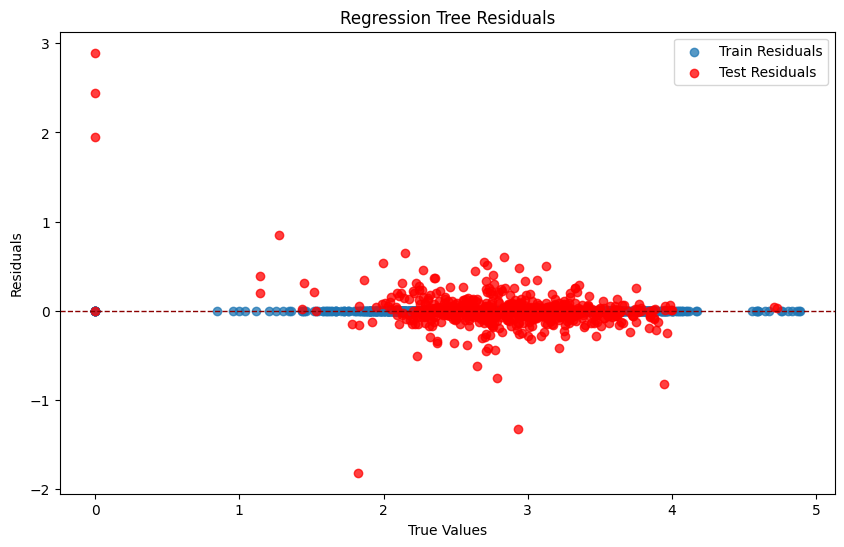

In [11]:
# Residuals plot
RT_train_residuals = y_pred_train_rt - y_train
RT_test_residuals = y_pred_test_rt - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, RT_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, RT_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Regression Tree Residuals")
ax.legend()
plt.show()

RT_residuals_plot = fig

The MSE on the test set is improving, but let's see if we can improve this with cross-validation.

### **Model 3: Cross-Validated and Parameter Searched Regression Tree**

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'ccp_alpha': np.arange(.01, .25, .001)
}

# Perform a grid search with cross-validation
new_regr_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=new_regr_tree, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the best model from the grid search
cv_regr_tree = grid_search.best_estimator_
cv_regr_tree.fit(X_train, y_train)

# Make predictions with the best model
y_pred_train_cv = cv_regr_tree.predict(X_train)
y_pred_test_cv = cv_regr_tree.predict(X_test)

# Evaluate the best model
mse_train = mean_squared_error(y_train, y_pred_train_cv)
mse_test = mean_squared_error(y_test, y_pred_test_cv)
r2_train = r2_score(y_train, y_pred_train_cv)
r2_test = r2_score(y_test, y_pred_test_cv)

# Print evaluation metrics and best parameters
print("Best Parameters:", grid_search.best_params_)
print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Best Parameters: {'ccp_alpha': 0.01}
Train MSE: 0.08750569531205542
Test MSE: 0.1151783006286558
Train R^2: 0.7008469076676532
Test R^2: 0.61522322781675


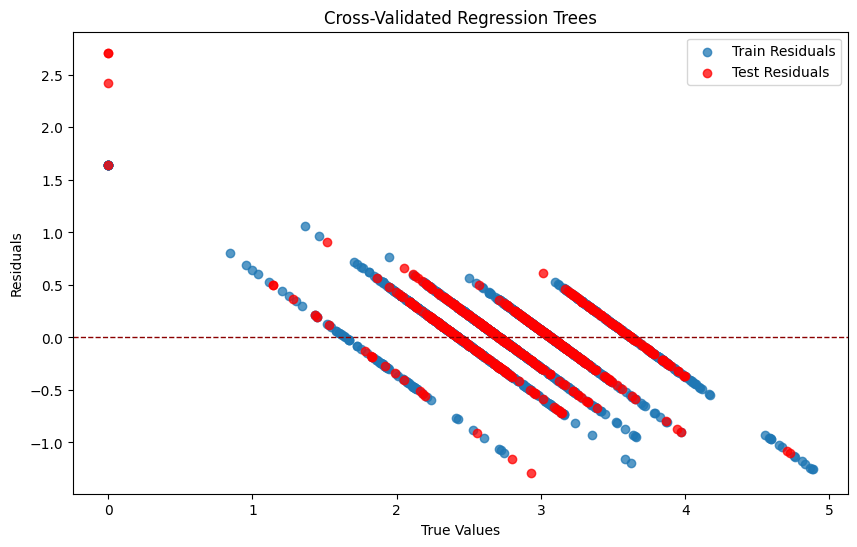

In [13]:
# Residuals plot
CV_train_residuals = y_pred_train_cv - y_train
CV_test_residuals = y_pred_test_cv - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, CV_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, CV_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Cross-Validated Regression Trees")
ax.legend()
plt.show()

CV_residuals_plot = fig

### **Model 4: Random Forest**

In [14]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
rf.fit(X_train, y_train)

# Make predictions with the best model
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Evaluate the best model
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# Print evaluation metrics
print("Train MSE (Random Forest):", mse_train_rf)
print("Test MSE (Random Forest):", mse_test_rf)
print("Train R^2 (Random Forest):", r2_train_rf)
print("Test R^2 (Random Forest):", r2_test_rf)

Train MSE (Random Forest): 0.0032526389418490466
Test MSE (Random Forest): 0.0483646925042815
Train R^2 (Random Forest): 0.9888803009424153
Test R^2 (Random Forest): 0.8384278100314073


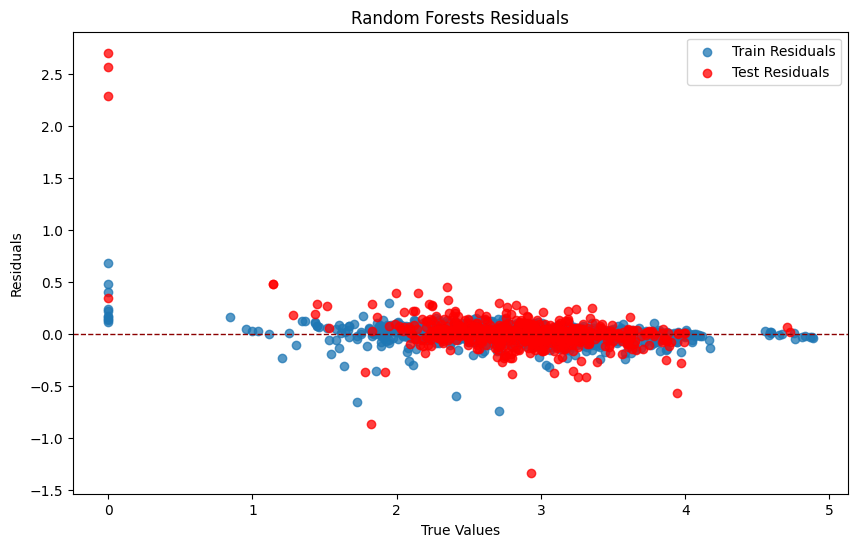

In [15]:
# Residuals plot
RF_train_residuals = y_pred_train_rf - y_train
RF_test_residuals = y_pred_test_rf - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, RF_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, RF_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Random Forests Residuals")
ax.legend()
plt.show()

RF_residuals_plot = fig

### **Model 5: Gradient Boosting**

In [16]:
# Initialize Gradient Boosting Regressor with a different variable name
gradient_boosting_model = GradientBoostingRegressor(random_state=42)

# Fit the model on training data
gradient_boosting_model.fit(X_train, y_train)

# Make predictions with the fitted model
y_pred_train_gbm = gradient_boosting_model.predict(X_train)
y_pred_test_gbm = gradient_boosting_model.predict(X_test)

# Evaluate the model
mse_train_gbm = mean_squared_error(y_train, y_pred_train_gbm)
mse_test_gbm = mean_squared_error(y_test, y_pred_test_gbm)
r2_train_gbm = r2_score(y_train, y_pred_train_gbm)
r2_test_gbm = r2_score(y_test, y_pred_test_gbm)

# Print evaluation metrics
print("Train MSE (Gradient Boosting):", mse_train_gbm)
print("Test MSE (Gradient Boosting):", mse_test_gbm)
print("Train R^2 (Gradient Boosting):", r2_train_gbm)
print("Test R^2 (Gradient Boosting):", r2_test_gbm)

Train MSE (Gradient Boosting): 0.014311706779352116
Test MSE (Gradient Boosting): 0.05267286895222789
Train R^2 (Gradient Boosting): 0.9510729978851198
Test R^2 (Gradient Boosting): 0.8240354616585899


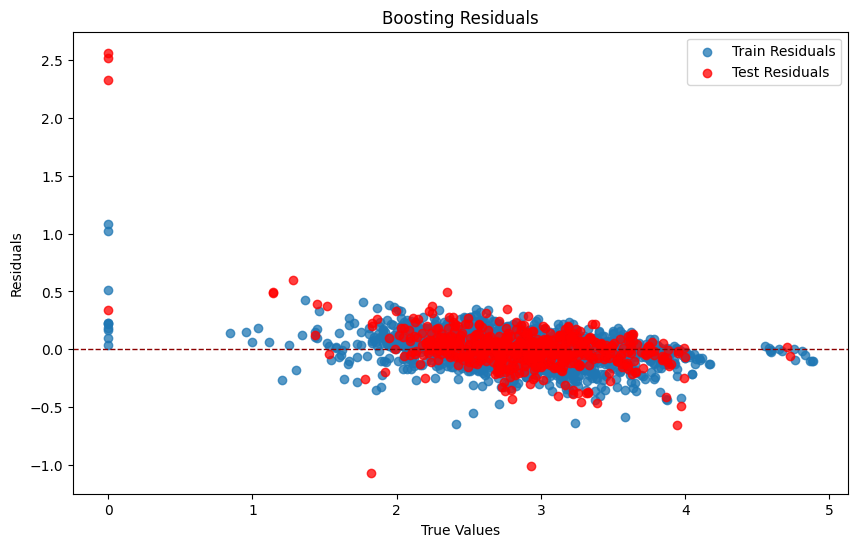

In [17]:
# Residuals plot
GBM_train_residuals = y_pred_train_gbm - y_train
GBM_test_residuals = y_pred_test_gbm - y_test

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_train, GBM_train_residuals, alpha=0.75, label="Train Residuals")
ax.scatter(y_test, GBM_test_residuals, alpha=0.75, label="Test Residuals", color="red")
ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
ax.set_xlabel("True Values")
ax.set_ylabel("Residuals")
ax.set_title("Boosting Residuals")
ax.legend()
plt.show()

GBM_residuals_plot = fig

## **Model Comparisons**

Lets look at how the residuals for each model compare towards each other.

In [18]:
# List of residuals and titles
residuals = [
    (LR_train_residuals, LR_test_residuals),
    (RT_train_residuals, RT_test_residuals),
    (CV_train_residuals, CV_test_residuals),
    (RF_train_residuals, RF_test_residuals),
    (GBM_train_residuals, GBM_test_residuals)
]
titles = [
    "Linear Regression Residuals",
    "Regression Tree Residuals",
    "Cross-Validation Residuals",
    "Random Forest Residuals",
    "Gradient Boosting Residuals"
]

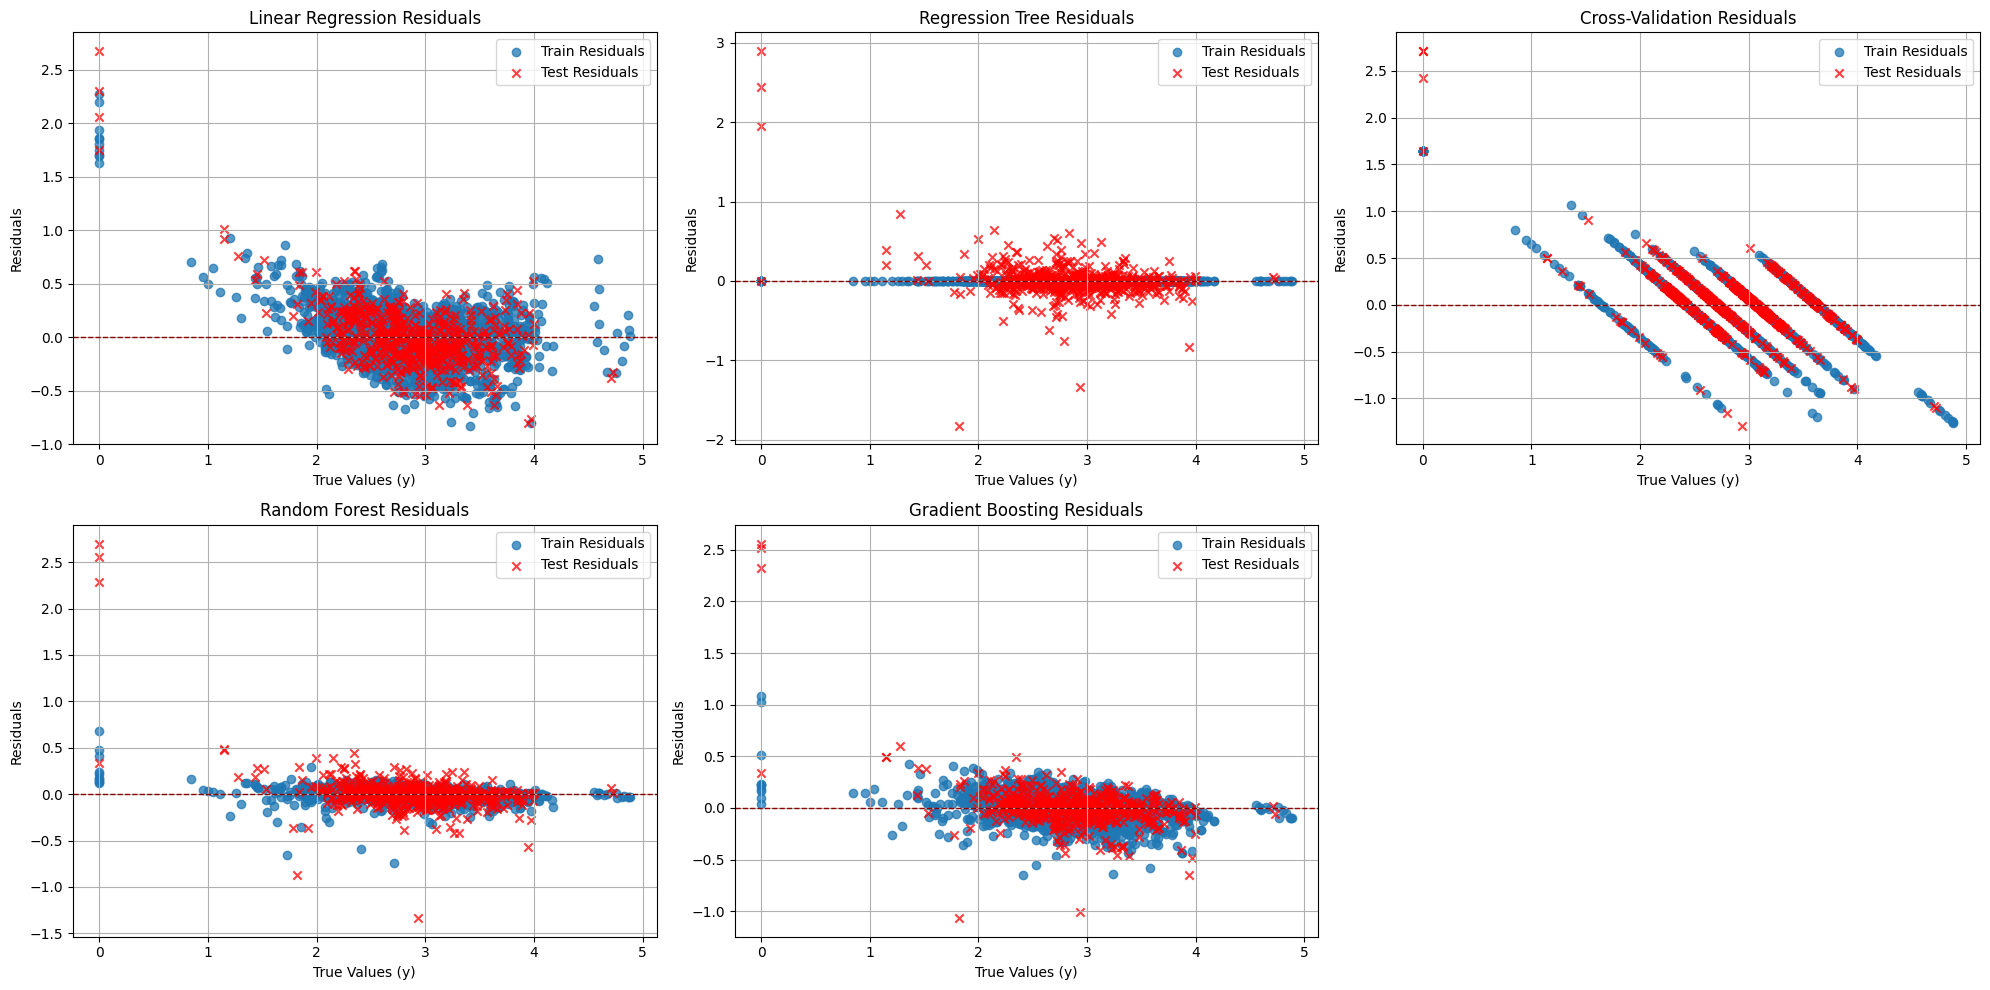

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

# Iterate through residuals and titles to plot
for i, ((train_res, test_res), title) in enumerate(zip(residuals, titles)):
    row, col = divmod(i, 3)  # Use 3 columns to determine subplot position
    ax = axes[row, col]
    
    # Scatter plots of y_train vs train_res and y_test vs test_res
    ax.scatter(y_train, train_res, alpha=0.75, label="Train Residuals", marker='o')
    ax.scatter(y_test, test_res, alpha=0.75, label="Test Residuals", marker='x', color="red")
    
    # Add a horizontal line at y=0 for reference
    ax.axhline(0, color="darkred", linestyle="--", linewidth=1)
    
    # Set title and labels
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("True Values (y)")
    ax.set_ylabel("Residuals")
    
    # Set grid and legend
    ax.grid(True)
    ax.legend()

# Turn off any unused subplot axes
for j in range(len(residuals), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

# Apply tight layout for better spacing
plt.tight_layout()
plt.show()

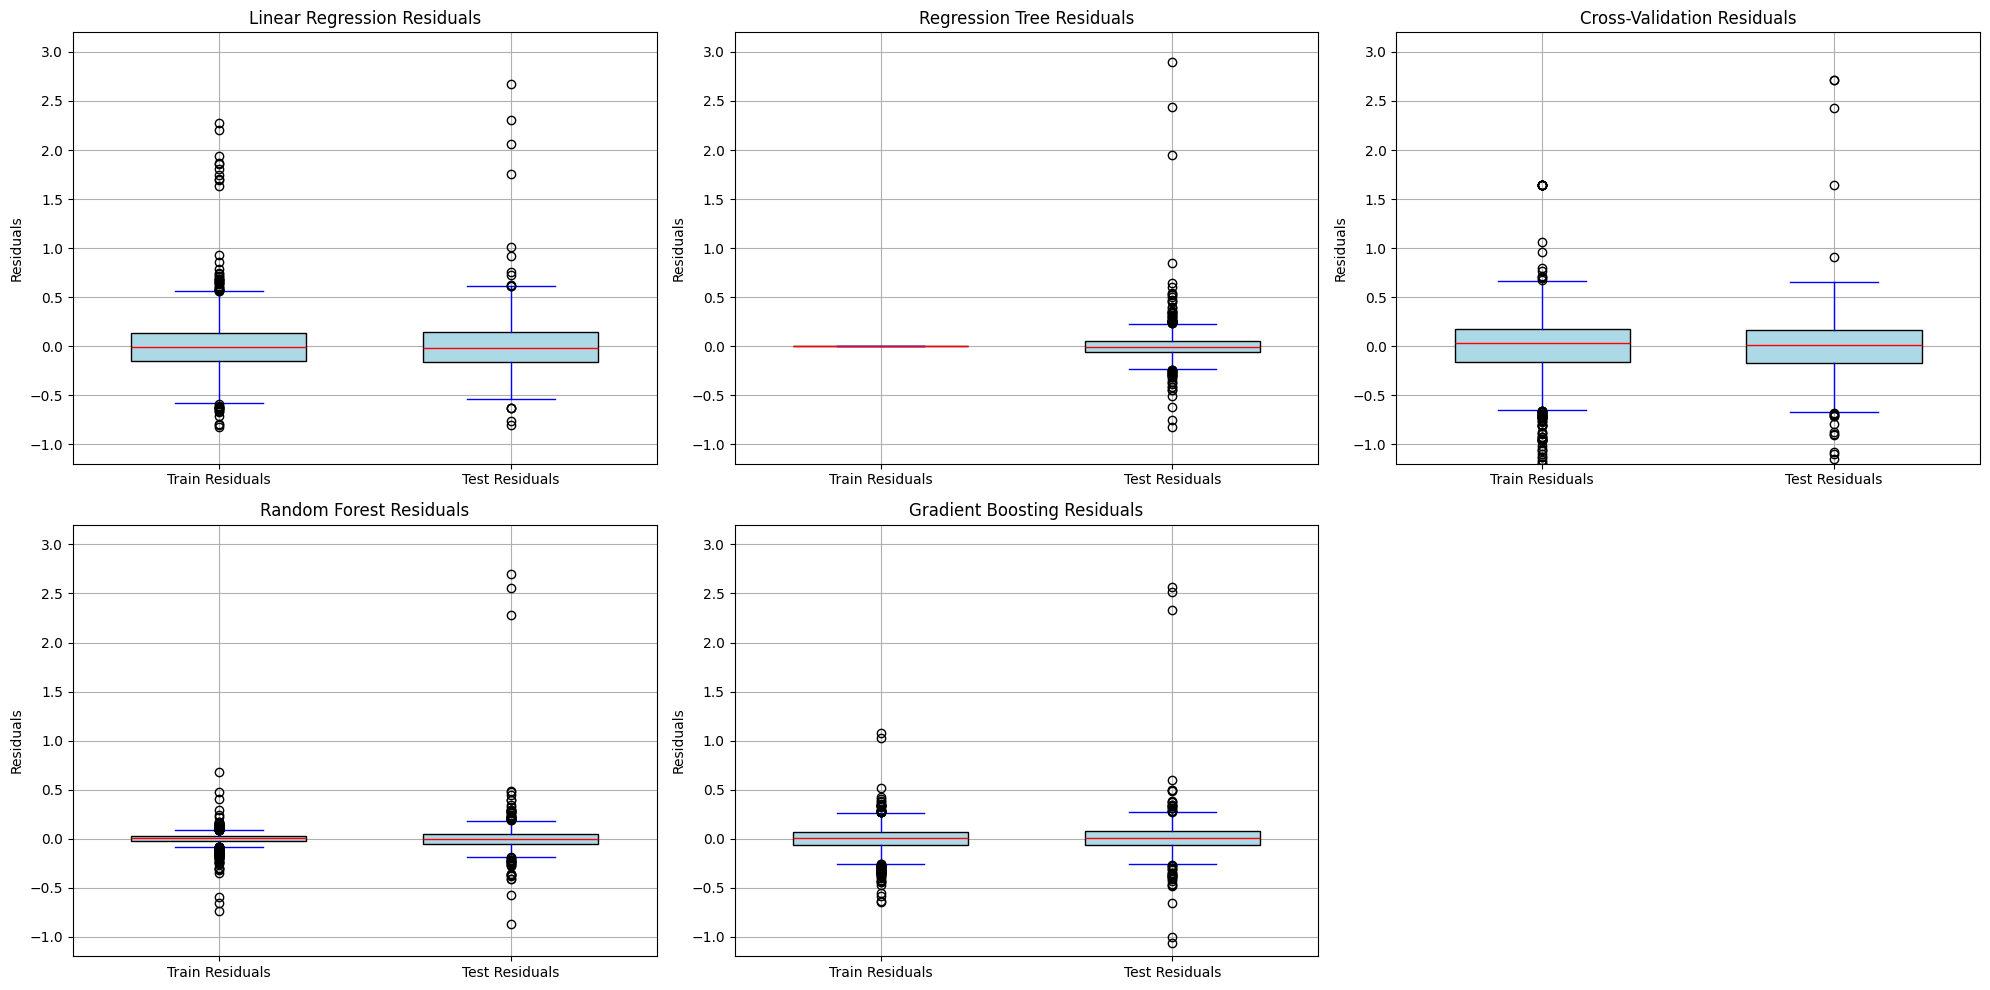

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows, 3 columns grid
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing

for i, ((train_res, test_res), title) in enumerate(zip(residuals, titles)):
    row, col = divmod(i, 3)  # Use 3 columns to determine subplot row and column
    ax = axes[row, col]
    
    # Create boxplots for train and test residuals
    ax.boxplot(
        [train_res, test_res],
        positions=[1, 2],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue"),
        medianprops=dict(color="red"),
        whiskerprops=dict(color="blue"),
        capprops=dict(color="blue")
    )
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["Train Residuals", "Test Residuals"])
    ax.set_ylim(-1.2, 3.2)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Residuals")
    ax.grid(True)

# Turn off any unused subplot axes
for j in range(len(residuals), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

# Apply tight layout for better spacing
plt.tight_layout()
plt.show()

### **Bootstrap Aggregation**

We can simply choose a model with the best $R^2$ value but let's truly confirm how accurate our dataset can be by performing bootstrap samples.

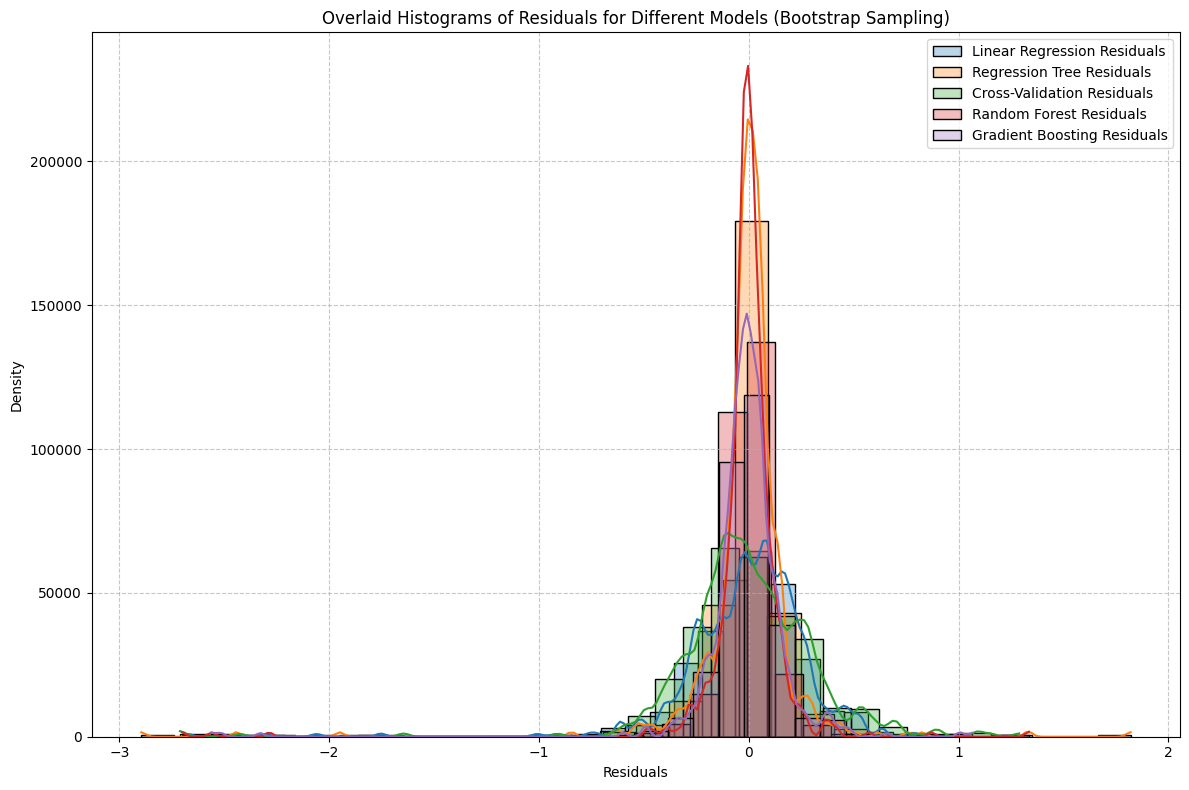

In [21]:
models = [linear_model, regr_tree, cv_regr_tree, rf, gradient_boosting_model]

# Perform bootstrapping for each model and calculate residuals
bootstrap_residuals = {}
for model, title in zip(models, titles):
    np.random.seed(2024)
    residuals = []
    for _ in range(500):  # 500 iterations
        indices = np.random.choice(len(X_test), size=len(X_test), replace=True) # REPLACE WITH WHOLE DATASET
        X_bootstrap = X_test.iloc[indices, :]
        y_bootstrap = y_test.iloc[indices]
        y_pred_bootstrap = model.predict(X_bootstrap)
        residuals.extend(y_bootstrap - y_pred_bootstrap)  # Collect residuals
    bootstrap_residuals[title] = residuals

# Plot overlaid histograms of residuals for each model
plt.figure(figsize=(12, 8))
for title, residuals in bootstrap_residuals.items():
    sns.histplot(residuals, kde=True, label=title, bins=30, alpha=0.3)

plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Overlaid Histograms of Residuals for Different Models (Bootstrap Sampling)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()